# Определение жанра по изображению обложки музыкального диска

Очевидно, что оформление музыкального альбома как-то связано с его содержанием. Но насколько связано? Как подтвердить это, опираясь на данные? И чем это может быть полезно?


### Основная задача

Необходимо разработать модель, которая определит жанр музыкального альбома по изображению его обложки.

### Данные

Изображения в формате PNG.  

### Метрика

Метрики для классификации: Accuracy, Precision, Recall, F1.

### План реализации


- Загрузка данных
- Предобработка и анализ  данных
- Обучение модели 
- Заключение  


### Инструменты

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report

import os
import shutil
from shutil import copyfile
from os import listdir
from os.path import isfile, join
from pathlib import Path
from collections import Counter

import fastai
from fastai.vision.all import *
from fastai.callback.fp16 import *
from fastai.vision import models
from fastai.metrics import error_rate, accuracy

import warnings
warnings.filterwarnings("ignore")


### Загрузка данных

In [2]:
%load_ext watermark
%watermark -a 'Music_genres' -u -d -v -p pandas,sklearn,numpy,matplotlib


Author: Music_genres

Last updated: 2024-04-30

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

pandas    : 2.0.3
sklearn   : 1.3.0
numpy     : 1.24.3
matplotlib: 3.7.2



In [3]:
# путь к директории, где находятся все папки с фотографиями
root_dir = '/Users/urvanov_aleksandr/Documents/Yandex/Projects/music_covers/genres' 

# список для хранения имен файлов и соответствующих им папок
files_and_folders = []

# перебор всех папок в директории
for folder_name in os.listdir(root_dir):
    if not os.path.isdir(os.path.join(root_dir, folder_name)):
        continue  
    
    # получаем путь к текущей папке
    current_directory = os.path.join(root_dir, folder_name)
    
    # перебор всех файлов в папке
    for filename in os.listdir(current_directory):
        file_path = os.path.join(current_directory, filename)
        files_and_folders.append((filename, folder_name))

# создание DataFrame из списка с именами файлов и жанра
df = pd.DataFrame(files_and_folders, columns=['fname', 'class_label'])

# перемешаем датафрейм
df = df.sample(frac=1).reset_index(drop=True)

# выведем датафрейм
display(df)


,fname,class_label
0,2fca1b4d-f307-48fc-a449-550e663c9da0.png,edm
1,75844a1c-9bbc-4781-8186-c4756f09c7ae.png,pop
2,2d9af166-11ac-3b19-8ae3-26f188d7da13.png,jazz
3,400499e3-026f-4ddb-9cfe-eca61a81ae23.png,country
4,6bd0abe5-1510-4099-9be7-7a1e82ae9ddf.png,classical
...,...,...
7795,b28b6cb0-bd4a-43bf-9bc8-1ddc88c39682.png,black metal
7796,cda51c25-adb9-4781-b644-90333137138b.png,country
7797,9985aba1-3a60-4666-87cf-d7e27ad2ca27.png,anime
7798,ba959643-e5bb-4273-b527-7a59453e96b2.png,country


#### Вывод 

Данные загружены и собраны в один датафрейм в 7800 строк, что не так много для обучения.

### Предобработка и анализ  данных

Выведем информацию о датафрейме

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7800 entries, 0 to 7799
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   fname        7800 non-null   object
 1   class_label  7800 non-null   object
dtypes: object(2)
memory usage: 122.0+ KB


Проверим на наличие дубликатов в фото

In [5]:
df['fname'].duplicated().sum()

4

Удалим дубликаты в столбце

In [6]:
df = df.drop_duplicates (subset=['fname']).reset_index(drop=True)

Проверим жанры

In [7]:
df['class_label'].value_counts()

class_label
country        1486
anime          1189
classical       955
jazz            821
pop             802
edm             719
reggae          581
disco           467
black metal     450
rap             326
Name: count, dtype: int64

Наблюдаем дисбаланс классов

Скинем все фото в отдельную папку

In [8]:
# путь к исходной директории с папками
source_directory = '/Users/urvanov_aleksandr/Documents/Yandex/Projects/music_covers/genres'

# путь, куда будут скопированы фото
target_directory = '/Users/urvanov_aleksandr/Documents/Yandex/Projects/music_covers/data_foto'

# перебираем все файлы в исходной директории
for root, dirs, files in os.walk(source_directory):
    for file in files:
        # получаем полный путь к текущему файлу
        source_file = os.path.join(root, file)
        
        # проверяем, существует ли уже файл в целевой директории
        target_file = os.path.join(target_directory, file)
        if not os.path.exists(target_file):
            # если файла нет, копируем его
            shutil.copy2(source_file, target_directory)
else:
    print("Все фотографии были скопированы в отдельную папку.")

Все фотографии были скопированы в отдельную папку.


Обозначим классы 

In [9]:
df['label'] = df['class_label'].apply(lambda x: [x])

Для предотвращения переучивания модели увеличим тренировочную часть

In [10]:
setup_aug = setup_aug_tfms([Rotate(max_deg=90, p=0.75), Zoom(), Flip()])

Предобрабатываем и разделяем данные на тренироваочную и валидационную часть

In [11]:
photo_data = ImageDataLoaders.from_df(
    df,
    fn_col='fname',
    label_col='label',
    splitter=RandomSplitter(seed=42),
 #   valid_pct=0.3,
    y_block=MultiCategoryBlock,
    folder="/Users/urvanov_aleksandr/Documents/Yandex/Projects/music_covers/data_foto",
    bs=16,
    item_tfms=Resize(224),
    batch_tfms=setup_aug,
)

Проверим какие метки содержат наши данные

In [12]:
photo_data.vocab

['anime', 'black metal', 'classical', 'country', 'disco', 'edm', 'jazz', 'pop', 'rap', 'reggae']

Проверим размеры и тип векторов

In [13]:
x, y = photo_data.one_batch()

In [14]:
type(x), type(y)

(fastai.torch_core.TensorImage, fastai.torch_core.TensorMultiCategory)

In [15]:
x.shape, y.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 10]))

Выведем примеры обложек из обучающего набора

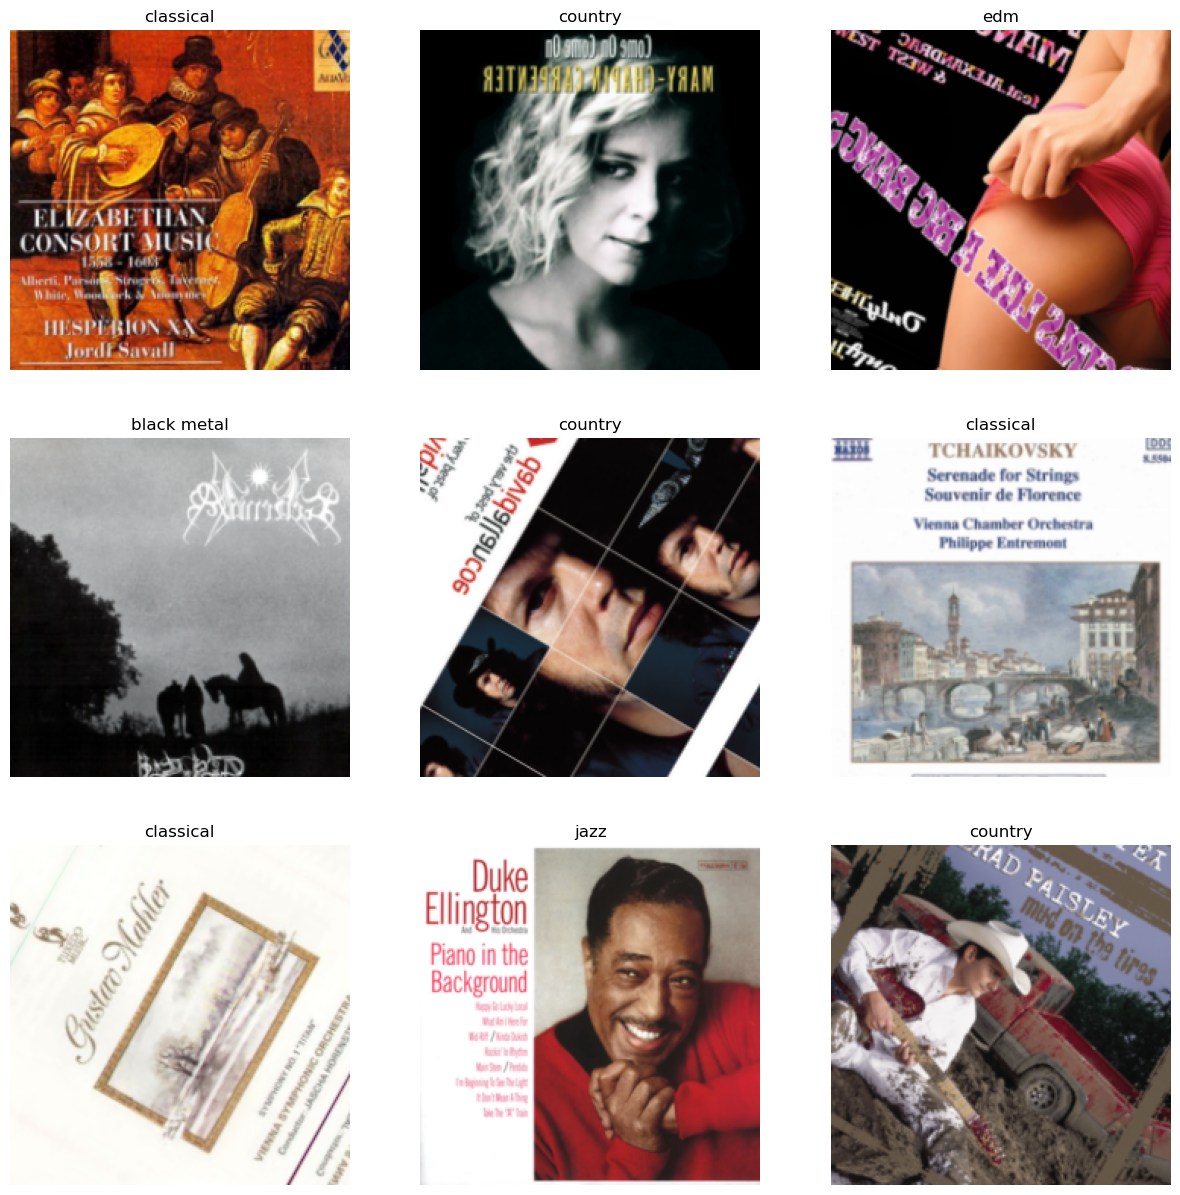

In [16]:
photo_data.show_batch(figsize=(15,15))

#### Вывод 

Данные готовы к обучению, наблюдается дисбаланс классов.

### Обучение модели 

Используем предобученную модель resnet50

In [17]:
learn = cnn_learner(photo_data, resnet50, metrics=[F1ScoreMulti(), accuracy_multi]).to_fp16()

Обучение модели 

In [18]:
learn.fine_tune(18, freeze_epochs=3)

epoch,train_loss,valid_loss,f1_score,accuracy_multi,time
0,0.694802,0.467434,0.365123,0.792046,04:12
1,0.278083,0.208215,0.424202,0.923220,04:12
2,0.241508,0.194778,0.446869,0.927582,04:13


epoch,train_loss,valid_loss,f1_score,accuracy_multi,time
0,0.204340,0.170050,0.517559,0.935856,05:10
1,0.185420,0.161705,0.566511,0.938935,05:09
2,0.177951,0.152896,0.589370,0.941437,05:10
3,0.170864,0.152368,0.638373,0.944644,05:13
4,0.147397,0.146995,0.644437,0.945221,05:12
5,0.132943,0.154363,0.636122,0.943810,05:11
6,0.127685,0.158600,0.631696,0.942848,05:10
7,0.108432,0.165117,0.628319,0.943618,05:09
8,0.091767,0.167712,0.647635,0.944131,05:10
9,0.077363,0.174082,0.655403,0.944836,05:09


SuggestedLRs(valley=0.00010964782268274575)

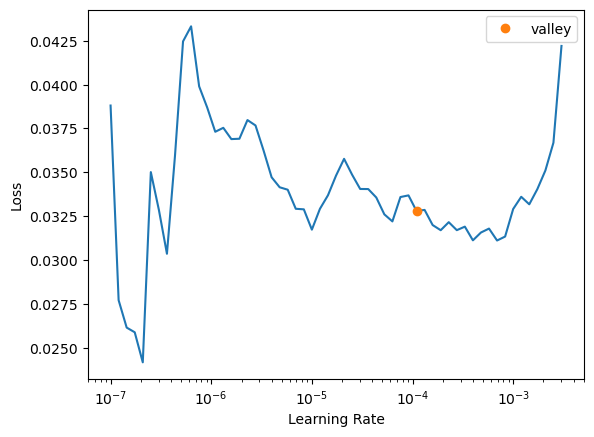

In [19]:
# выведем, рекомендуемую скорость обучения
learn.lr_find()

Сформируем пару предсказания и истинной метки

In [20]:
y_pred, y_true = learn.get_preds()

Выведем метрики модели по каждому жанру

In [21]:
print(classification_report(y_true, y_pred>0.50, 
                            target_names=photo_data.vocab, zero_division=1))

              precision    recall  f1-score   support

       anime       0.92      0.74      0.82       249
 black metal       0.90      0.91      0.91        90
   classical       0.88      0.86      0.87       194
     country       0.79      0.68      0.73       318
       disco       0.46      0.29      0.35        77
         edm       0.69      0.53      0.60       131
        jazz       0.64      0.55      0.59       154
         pop       0.60      0.46      0.52       158
         rap       0.79      0.51      0.62        65
      reggae       0.72      0.55      0.63       123

   micro avg       0.77      0.64      0.70      1559
   macro avg       0.74      0.61      0.66      1559
weighted avg       0.76      0.64      0.69      1559
 samples avg       0.82      0.64      0.82      1559



#### Вывод 

Пример работы модели 

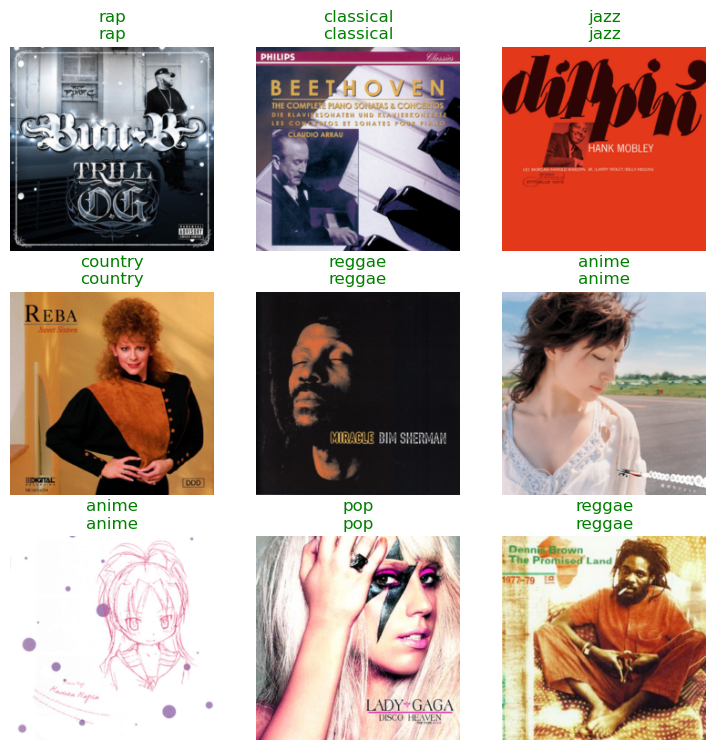

In [22]:
learn.show_results()

### Заключение  

Samples avg (f1-score) = 0.82 средняя оценка, считая все категории равноправными. В целом модель обучилась хорошо, но из-за дисбаланса классов метрика хуже, чем могла бы быть. Рекомендацией является увеличение размера текущего набора данных, а точнее малочисленных класоов с f1-score < 0,6 : disco, jazz, pop. Это позволит улучшить метрику и качество работы модели. 